### 异常检测

使用高斯模型实现异常检测算法，并将其应用于检测网络上的故障服务器。

第一个任务：使用高斯模型来检测二维数据集中未标记的示例是否应被视为异常。

#### 数据可视化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('./datasets/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

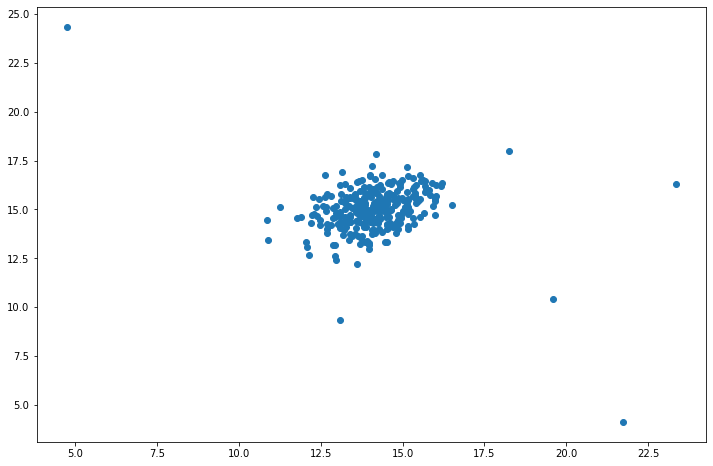

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

#### 高斯分布参数，绘制等高线

In [4]:
# 计算高斯分布参数u,σ
# 输入矩阵，输出2个n维向量，mu包含了每一个维度的平均值，sigma包含了每一个维度的方差
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

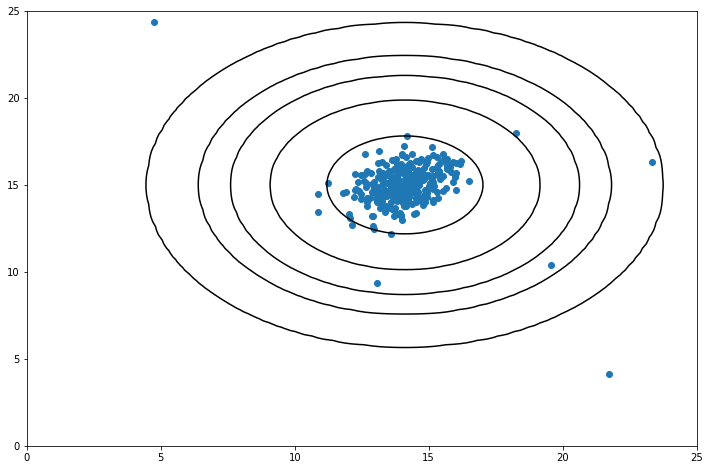

In [6]:
# 将0-25等分，分为100个点
xplot = np.linspace(0,25,100)
yplot = np.linspace(0,25,100)
# 生成网格状的数据，因为等高线的显示是在网格的基础上添加上高度值
Xplot, Yplot = np.meshgrid(xplot,yplot)

Z = np.exp((-0.5)*((Xplot-mu[0])**2/sigma[0]+(Yplot-mu[1])**2/sigma[1]))

fig, ax = plt.subplots(figsize=(12,8))
# 绘制等高线
# Xplot, Yplot：值Z的坐标；Z：绘制轮廓的高度值，levels：int或者类数组，确定轮廓线/区域的数量和位置
contour = plt.contour(Xplot, Yplot, Z,[10**-11, 10**-7, 10**-5, 10**-3, 0.1],colors='k')
ax.scatter(X[:,0], X[:,1])
plt.show()

#### 选择阈值

In [7]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

In [8]:
# eg:计算数据点的概率密度函数
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

In [9]:
# eg:
dist.pdf(X[:,0])[0:50]

array([0.183842  , 0.20221694, 0.21746136, 0.19778763, 0.20858956,
       0.21652359, 0.16991291, 0.15123542, 0.1163989 , 0.1594734 ,
       0.21716057, 0.21760472, 0.20141857, 0.20157497, 0.21711385,
       0.21758775, 0.21695576, 0.2138258 , 0.21057069, 0.1173018 ,
       0.20765108, 0.21717452, 0.19510663, 0.21702152, 0.17429399,
       0.15413455, 0.21000109, 0.20223586, 0.21031898, 0.21313426,
       0.16158946, 0.2170794 , 0.17825767, 0.17414633, 0.1264951 ,
       0.19723662, 0.14538809, 0.21766361, 0.21191386, 0.21729442,
       0.21238912, 0.18799417, 0.21259798, 0.21752767, 0.20616968,
       0.21520366, 0.1280081 , 0.21768113, 0.21539967, 0.16913173])

In [10]:
# 计算并保存给定上述的高斯模型参数的数据集中每个值的概率密度
p = np.zeros((X.shape[0], X.shape[1]))
print(p.shape)
p[:, 0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

print(p.shape)

(307, 2)
(307, 2)


In [11]:
# 为验证集（使用相同的模型参数）执行此操作
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

#### 选择一个阈值ε，来判断哪些是异常点(正常0，异常1),使F1_score分数最高

In [12]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    #epsilon在pval最小最大值遍历,找到best_epsilon
    for epsilon in np.arange(pval.min(), pval.max(), step):
        # preds 0/1 ，如果pval<espilon成立，返回布尔值1，反之0       
        preds = pval < epsilon 
        
        # tp是异常值、并且我们的模型预测成异常值了        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        # fp是正常值、但模型把它预测成异常值        
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        # fn是异常值，但是模型把它预测成正常值 
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        # 精确度
        precision = tp / (tp + fp)
        # 召回率 
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [13]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

<ipython-input-12-9b3ca04554bc>:21: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp / (tp + fp)


(0.009566706005956842, 0.7142857142857143)

#### 将阈值应用于数据集，并可视化结果

In [14]:
# indexes of the values considered to be outliers
# 索引异常点，返回值：行+列
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

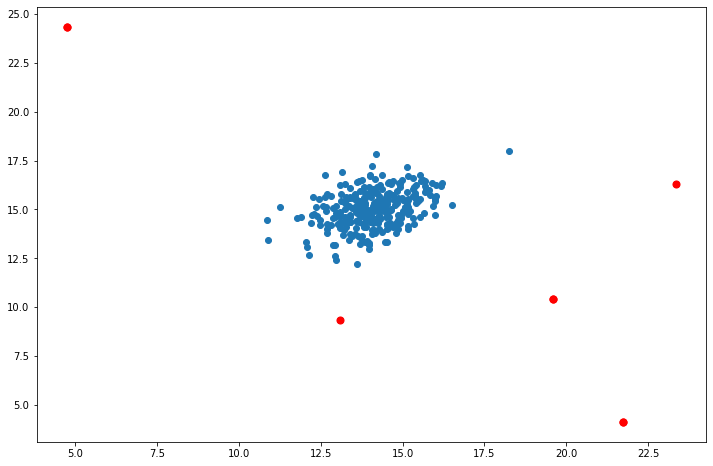

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()